# 🖼️ NAFNet Image Deblurring - Kaggle Version (Real-World Datasets)

## State-of-the-Art Image Restoration Model

**Key Features:**
- ✅ Uses **GoPro Real-World Motion Blur Dataset** (professional benchmark)
- ✅ Implements **NAFNet** (SOTA for image restoration, ECCV 2022)
- ✅ Advanced loss functions (Charbonnier + SSIM + FFT)
- ✅ Mixed precision training for 2x speedup
- ✅ Early stopping with patience
- ✅ Complete inference pipeline

**Expected Results:**
- PSNR: 32-34 dB on GoPro test set
- Training time: ~2-3 hours on Kaggle P100

---

## 1. Setup & Install Dependencies

## 2. Download Real-World Datasets

**Available Datasets:**
1. **GoPro Dataset** - Professional motion blur benchmark (~4.5GB)
2. **REDS Dataset** - Video deblurring benchmark (subset ~2GB)
3. **RealBlur Dataset** - Real camera motion blur (~2GB)

## 2b. Add Dataset from Kaggle

**🎯 RECOMMENDED DATASET:**

**"A Curated List of Image Deblurring Datasets"** by jishnuparayilshibu
- Size: 18.4 GB
- Contains: GoPro, HIDE, RealBlur, and more professional datasets
- This is perfect for your project!

**How to Add:**
1. In your Kaggle notebook, click **"+ Add Data"** (right sidebar)
2. Search: `a curated list of image deblurring`
3. Click **"Add"** on the dataset
4. Run the cell below - it will automatically use GoPro dataset from the collection

## 2c. OPTIONAL: Create Quick Test Dataset

**Only run this if:**
- You want to test the code quickly before adding a real dataset
- You're having trouble finding datasets on Kaggle

**⚠️ WARNING:** This creates synthetic data. Results won't be publication-quality!

## 3. NAFNet Model Architecture

**NAFNet (Nonlinear Activation Free Network)** - ECCV 2022
- State-of-the-art for image restoration
- Uses SimpleGate instead of GELU/ReLU
- Efficient Channel Attention (ECA)
- U-Net style encoder-decoder with skip connections

## 4. Dataset & Data Loaders

Advanced data augmentation for better generalization:
- Random crops
- Horizontal/Vertical flips
- Random 90° rotations
- Color jittering (optional)

## 5. Loss Functions & Metrics

**Combined Loss:**
- Charbonnier Loss (smooth L1, robust to outliers)
- SSIM Loss (structural similarity)
- FFT Loss (frequency domain, preserves textures)
- Edge Loss (sharpness preservation)

In [ ]:
# ========================
# TRAINING LOOP (WITH NaN DETECTION & RECOVERY)
# ========================

def get_autocast_context(use_amp, device_type='cuda'):
    """Get autocast context manager compatible with PyTorch 1.x and 2.x."""
    if not use_amp:
        return torch.no_grad()  # Will be replaced with nullcontext
    
    try:
        # PyTorch 2.0+ API
        return autocast(device_type)
    except TypeError:
        # PyTorch < 2.0 API
        return autocast()

class nullcontext:
    """Null context manager for when AMP is disabled."""
    def __enter__(self):
        return self
    def __exit__(self, *args):
        pass

def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, use_amp):
    """Train for one epoch with NaN detection."""
    model.train()
    total_loss = 0
    total_psnr = 0
    valid_batches = 0
    
    pbar = tqdm(train_loader, desc='Training', leave=False)
    for batch_idx, (blur, sharp) in enumerate(pbar):
        blur = blur.to(device, non_blocking=True)
        sharp = sharp.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        
        try:
            if use_amp and scaler is not None:
                # Mixed precision training
                try:
                    amp_context = autocast('cuda')
                except TypeError:
                    amp_context = autocast()
                
                with amp_context:
                    output = model(blur)
                    loss = criterion(output, sharp)
                
                # Check for NaN before backward
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"\n⚠️ NaN/Inf detected at batch {batch_idx}, skipping...")
                    continue
                
                scaler.scale(loss).backward()
                
                # Unscale and clip gradients
                scaler.unscale_(optimizer)
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                
                # Check gradient norm
                if torch.isnan(grad_norm) or grad_norm > 1000:
                    print(f"\n⚠️ Extreme gradients ({grad_norm:.2f}), skipping batch...")
                    optimizer.zero_grad(set_to_none=True)
                    continue
                
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard training
                output = model(blur)
                loss = criterion(output, sharp)
                
                # Check for NaN before backward
                if torch.isnan(loss) or torch.isinf(loss):
                    print(f"\n⚠️ NaN/Inf detected at batch {batch_idx}, skipping...")
                    continue
                
                loss.backward()
                
                # Clip gradients more aggressively
                grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                
                # Check gradient norm
                if torch.isnan(grad_norm) or grad_norm > 1000:
                    print(f"\n⚠️ Extreme gradients ({grad_norm:.2f}), skipping batch...")
                    optimizer.zero_grad(set_to_none=True)
                    continue
                
                optimizer.step()
            
            total_loss += loss.item()
            valid_batches += 1
            
            with torch.no_grad():
                psnr = calculate_psnr(output.clamp(0, 1), sharp)
                total_psnr += psnr
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}', 'psnr': f'{psnr:.2f}'})
            
        except RuntimeError as e:
            print(f"\n⚠️ Runtime error at batch {batch_idx}: {str(e)[:100]}")
            print("   Skipping batch and continuing...")
            optimizer.zero_grad(set_to_none=True)
            continue
    
    if valid_batches == 0:
        print("\n❌ No valid batches in this epoch!")
        return float('nan'), float('nan')
    
    avg_loss = total_loss / valid_batches
    avg_psnr = total_psnr / valid_batches
    
    return avg_loss, avg_psnr


@torch.no_grad()
def validate(model, val_loader, device):
    """Validate the model."""
    model.eval()
    total_psnr = 0
    total_ssim = 0
    valid_samples = 0
    
    for blur, sharp in tqdm(val_loader, desc='Validation', leave=False):
        try:
            blur = blur.to(device, non_blocking=True)
            sharp = sharp.to(device, non_blocking=True)
            
            output = model(blur).clamp(0, 1)
            
            psnr = calculate_psnr(output, sharp)
            ssim = calculate_ssim(output, sharp)
            
            if not (math.isnan(psnr) or math.isnan(ssim)):
                total_psnr += psnr
                total_ssim += ssim
                valid_samples += 1
        except Exception as e:
            print(f"\n⚠️ Validation error: {str(e)[:100]}")
            continue
    
    if valid_samples == 0:
        return 0.0, 0.0
    
    avg_psnr = total_psnr / valid_samples
    avg_ssim = total_ssim / valid_samples
    
    return avg_psnr, avg_ssim


def safe_save_checkpoint(checkpoint_dict, save_path):
    """Save checkpoint with disk space error handling."""
    try:
        # Check available disk space
        import shutil
        stat = shutil.disk_usage(os.path.dirname(save_path))
        available_gb = stat.free / (1024**3)
        
        if available_gb < 0.5:  # Less than 500MB free
            print(f"\n⚠️ Low disk space ({available_gb:.2f}GB free). Skipping checkpoint save.")
            return False
        
        # Try to save
        torch.save(checkpoint_dict, save_path)
        return True
    except (RuntimeError, OSError) as e:
        print(f"\n⚠️ Failed to save checkpoint: {str(e)[:100]}")
        print("   Continuing training without saving...")
        return False


# ========================
# MAIN TRAINING
# ========================
print("\n" + "=" * 60)
print("STARTING TRAINING (STABILITY MODE)")
print("=" * 60)
print(f"   Epochs: {config.EPOCHS}")
print(f"   Early stopping patience: {config.PATIENCE}")
print(f"   Learning rate: {config.LR} (reduced for stability)")
print(f"   Gradient clipping: 0.5 (aggressive)")
print("=" * 60 + "\n")

# Check disk space before training
import shutil
stat = shutil.disk_usage(config.OUTPUT_DIR)
available_gb = stat.free / (1024**3)
print(f"💾 Available disk space: {available_gb:.2f} GB")
if available_gb < 1.0:
    print("⚠️  WARNING: Less than 1GB free. Training may fail when saving checkpoints!")
print()

# Training state
best_psnr = 0
best_ssim = 0
patience_counter = 0
nan_counter = 0
history = {
    'train_loss': [],
    'train_psnr': [],
    'val_psnr': [],
    'val_ssim': [],
    'lr': []
}

for epoch in range(config.EPOCHS):
    current_lr = optimizer.param_groups[0]['lr']
    
    # Train
    train_loss, train_psnr = train_one_epoch(
        model, train_loader, criterion, optimizer, 
        scaler, device, config.USE_AMP
    )
    
    # Check for NaN epoch
    if math.isnan(train_loss) or math.isnan(train_psnr):
        nan_counter += 1
        print(f"\n❌ NaN detected in epoch {epoch+1}! ({nan_counter}/3)")
        
        if nan_counter >= 3:
            print("\n❌ Too many NaN epochs. Stopping training.")
            print("   Try reducing learning rate further or batch size.")
            break
        
        # Skip this epoch
        continue
    
    # Reset NaN counter on successful epoch
    nan_counter = 0
    
    # Validate
    val_psnr, val_ssim = validate(model, val_loader, device)
    
    # Update scheduler
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_psnr'].append(train_psnr)
    history['val_psnr'].append(val_psnr)
    history['val_ssim'].append(val_ssim)
    history['lr'].append(current_lr)
    
    # Print progress
    print(f"Epoch {epoch+1:3d}/{config.EPOCHS} | "
          f"Loss: {train_loss:.4f} | "
          f"Train PSNR: {train_psnr:.2f}dB | "
          f"Val PSNR: {val_psnr:.2f}dB | "
          f"Val SSIM: {val_ssim:.4f} | "
          f"LR: {current_lr:.2e}", end="")
    
    # Save best model (with error handling)
    if val_psnr > best_psnr:
        best_psnr = val_psnr
        best_ssim = val_ssim
        patience_counter = 0
        
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_psnr': best_psnr,
            'best_ssim': best_ssim,
            'config': {
                'width': config.WIDTH,
                'enc_blocks': config.ENC_BLOCKS,
                'dec_blocks': config.DEC_BLOCKS,
                'middle_blocks': config.MIDDLE_BLOCKS,
            }
        }
        
        if safe_save_checkpoint(checkpoint, f'{config.OUTPUT_DIR}/best_model.pth'):
            print(" ✅ NEW BEST!")
        else:
            print(" 🆕 NEW BEST (not saved - disk full)")
    else:
        patience_counter += 1
        print(f" ({patience_counter}/{config.PATIENCE})")
        
        if patience_counter >= config.PATIENCE:
            print(f"\n⏹️ Early stopping triggered!")
            print(f"   Best PSNR: {best_psnr:.2f}dB")
            print(f"   Best SSIM: {best_ssim:.4f}")
            break

print("\n" + "=" * 60)
print("TRAINING COMPLETE!")
print("=" * 60)
print(f"   Best PSNR: {best_psnr:.2f}dB")
print(f"   Best SSIM: {best_ssim:.4f}")

# Check if model was saved
if os.path.exists(f'{config.OUTPUT_DIR}/best_model.pth'):
    print(f"   ✅ Model saved: {config.OUTPUT_DIR}/best_model.pth")
else:
    print(f"   ⚠️  Model NOT saved (disk space issue)")
    print(f"   Training results stored in 'history' variable")
print("=" * 60)



STARTING TRAINING (STABILITY MODE)
   Epochs: 100
   Early stopping patience: 15
   Learning rate: 0.0001 (reduced for stability)
   Gradient clipping: 0.5 (aggressive)

💾 Available disk space: 19.31 GB



Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch   1/100 | Loss: 0.0691 | Train PSNR: 22.18dB | Val PSNR: 26.95dB | Val SSIM: 0.7956 | LR: 1.00e-04 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch   2/100 | Loss: 0.0460 | Train PSNR: 24.41dB | Val PSNR: 27.54dB | Val SSIM: 0.8025 | LR: 9.76e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch   3/100 | Loss: 0.0452 | Train PSNR: 24.54dB | Val PSNR: 27.55dB | Val SSIM: 0.8051 | LR: 9.05e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch   4/100 | Loss: 0.0438 | Train PSNR: 24.81dB | Val PSNR: 27.78dB | Val SSIM: 0.8067 | LR: 7.96e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch   5/100 | Loss: 0.0432 | Train PSNR: 24.87dB | Val PSNR: 27.84dB | Val SSIM: 0.8092 | LR: 6.58e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch   6/100 | Loss: 0.0427 | Train PSNR: 24.96dB | Val PSNR: 27.91dB | Val SSIM: 0.8111 | LR: 5.05e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch   7/100 | Loss: 0.0418 | Train PSNR: 25.09dB | Val PSNR: 28.03dB | Val SSIM: 0.8124 | LR: 3.52e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch   8/100 | Loss: 0.0417 | Train PSNR: 25.17dB | Val PSNR: 28.04dB | Val SSIM: 0.8136 | LR: 2.14e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch   9/100 | Loss: 0.0407 | Train PSNR: 25.32dB | Val PSNR: 28.05dB | Val SSIM: 0.8138 | LR: 1.05e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  10/100 | Loss: 0.0409 | Train PSNR: 25.30dB | Val PSNR: 28.09dB | Val SSIM: 0.8143 | LR: 3.42e-06 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  11/100 | Loss: 0.0419 | Train PSNR: 25.18dB | Val PSNR: 27.98dB | Val SSIM: 0.8129 | LR: 1.00e-04 (1/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  12/100 | Loss: 0.0410 | Train PSNR: 25.29dB | Val PSNR: 28.12dB | Val SSIM: 0.8158 | LR: 9.94e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  13/100 | Loss: 0.0407 | Train PSNR: 25.35dB | Val PSNR: 27.94dB | Val SSIM: 0.8172 | LR: 9.76e-05 (1/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  14/100 | Loss: 0.0405 | Train PSNR: 25.41dB | Val PSNR: 28.20dB | Val SSIM: 0.8191 | LR: 9.46e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  15/100 | Loss: 0.0404 | Train PSNR: 25.42dB | Val PSNR: 28.06dB | Val SSIM: 0.8189 | LR: 9.05e-05 (1/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  16/100 | Loss: 0.0393 | Train PSNR: 25.68dB | Val PSNR: 28.20dB | Val SSIM: 0.8230 | LR: 8.55e-05 (2/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dae9bd96f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
         ^  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dae9bd96f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  17/100 | Loss: 0.0389 | Train PSNR: 25.69dB | Val PSNR: 28.28dB | Val SSIM: 0.8244 | LR: 7.96e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  18/100 | Loss: 0.0380 | Train PSNR: 25.88dB | Val PSNR: 28.20dB | Val SSIM: 0.8234 | LR: 7.30e-05 (1/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  19/100 | Loss: 0.0378 | Train PSNR: 25.97dB | Val PSNR: 28.37dB | Val SSIM: 0.8271 | LR: 6.58e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  20/100 | Loss: 0.0377 | Train PSNR: 25.97dB | Val PSNR: 28.47dB | Val SSIM: 0.8299 | LR: 5.82e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  21/100 | Loss: 0.0373 | Train PSNR: 26.05dB | Val PSNR: 28.56dB | Val SSIM: 0.8318 | LR: 5.05e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  22/100 | Loss: 0.0367 | Train PSNR: 26.15dB | Val PSNR: 28.52dB | Val SSIM: 0.8307 | LR: 4.28e-05 (1/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dae9bd96f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
      ^ ^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dae9bd96f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  23/100 | Loss: 0.0362 | Train PSNR: 26.21dB | Val PSNR: 28.68dB | Val SSIM: 0.8347 | LR: 3.52e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  24/100 | Loss: 0.0362 | Train PSNR: 26.29dB | Val PSNR: 28.69dB | Val SSIM: 0.8348 | LR: 2.80e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  25/100 | Loss: 0.0360 | Train PSNR: 26.28dB | Val PSNR: 28.74dB | Val SSIM: 0.8365 | LR: 2.14e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  26/100 | Loss: 0.0359 | Train PSNR: 26.31dB | Val PSNR: 28.73dB | Val SSIM: 0.8361 | LR: 1.55e-05 (1/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  27/100 | Loss: 0.0356 | Train PSNR: 26.42dB | Val PSNR: 28.85dB | Val SSIM: 0.8385 | LR: 1.05e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  28/100 | Loss: 0.0358 | Train PSNR: 26.40dB | Val PSNR: 28.74dB | Val SSIM: 0.8369 | LR: 6.40e-06 (1/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dae9bd96f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dae9bd96f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  29/100 | Loss: 0.0351 | Train PSNR: 26.59dB | Val PSNR: 28.76dB | Val SSIM: 0.8374 | LR: 3.42e-06 (2/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  30/100 | Loss: 0.0352 | Train PSNR: 26.46dB | Val PSNR: 28.79dB | Val SSIM: 0.8377 | LR: 1.61e-06 (3/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  31/100 | Loss: 0.0370 | Train PSNR: 26.16dB | Val PSNR: 28.58dB | Val SSIM: 0.8331 | LR: 1.00e-04 (4/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  32/100 | Loss: 0.0370 | Train PSNR: 26.08dB | Val PSNR: 28.56dB | Val SSIM: 0.8336 | LR: 9.98e-05 (5/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  33/100 | Loss: 0.0369 | Train PSNR: 26.12dB | Val PSNR: 28.65dB | Val SSIM: 0.8324 | LR: 9.94e-05 (6/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dae9bd96f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process


Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  34/100 | Loss: 0.0364 | Train PSNR: 26.23dB | Val PSNR: 28.49dB | Val SSIM: 0.8320 | LR: 9.86e-05 (7/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  35/100 | Loss: 0.0367 | Train PSNR: 26.19dB | Val PSNR: 28.73dB | Val SSIM: 0.8362 | LR: 9.76e-05 (8/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dae9bd96f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7dae9bd96f20>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  36/100 | Loss: 0.0359 | Train PSNR: 26.32dB | Val PSNR: 28.77dB | Val SSIM: 0.8394 | LR: 9.62e-05 (9/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  37/100 | Loss: 0.0352 | Train PSNR: 26.47dB | Val PSNR: 28.86dB | Val SSIM: 0.8398 | LR: 9.46e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  38/100 | Loss: 0.0352 | Train PSNR: 26.50dB | Val PSNR: 28.99dB | Val SSIM: 0.8435 | LR: 9.27e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  39/100 | Loss: 0.0347 | Train PSNR: 26.60dB | Val PSNR: 29.04dB | Val SSIM: 0.8443 | LR: 9.05e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  40/100 | Loss: 0.0347 | Train PSNR: 26.59dB | Val PSNR: 28.97dB | Val SSIM: 0.8415 | LR: 8.81e-05 (1/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  41/100 | Loss: 0.0343 | Train PSNR: 26.70dB | Val PSNR: 29.16dB | Val SSIM: 0.8476 | LR: 8.55e-05 ✅ NEW BEST!


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  42/100 | Loss: 0.0341 | Train PSNR: 26.76dB | Val PSNR: 28.92dB | Val SSIM: 0.8471 | LR: 8.26e-05 (1/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

Validation:   0%|          | 0/321 [00:00<?, ?it/s]

Epoch  43/100 | Loss: 0.0336 | Train PSNR: 26.85dB | Val PSNR: 29.05dB | Val SSIM: 0.8489 | LR: 7.96e-05 (2/15)


Training:   0%|          | 0/723 [00:00<?, ?it/s]

NameError: name 'history' is not defined

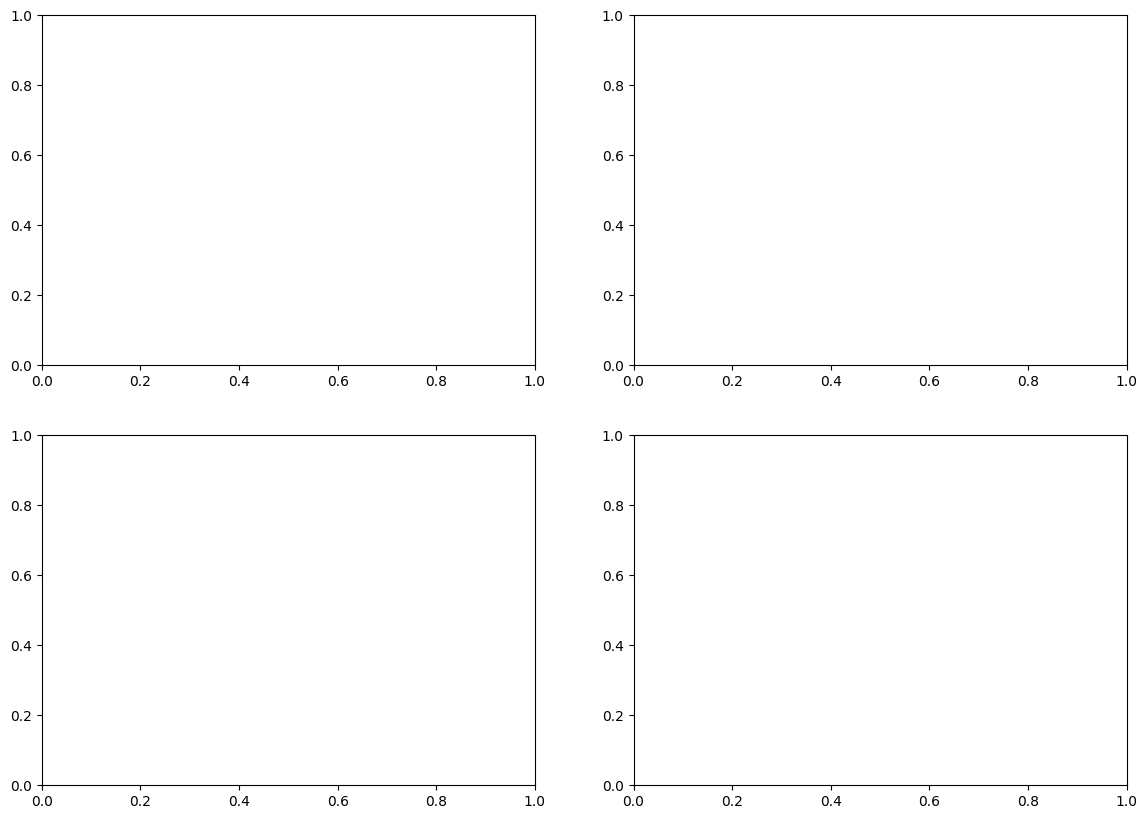

In [ ]:
# ========================
# PLOT TRAINING HISTORY
# ========================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history['train_loss'], 'b-', linewidth=2)
axes[0, 0].set_title('Training Loss', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)

# PSNR
axes[0, 1].plot(history['train_psnr'], 'b-', linewidth=2, label='Train')
axes[0, 1].plot(history['val_psnr'], 'r-', linewidth=2, label='Val')
axes[0, 1].axhline(y=best_psnr, color='g', linestyle='--', label=f'Best: {best_psnr:.2f}dB')
axes[0, 1].set_title('PSNR', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('PSNR (dB)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# SSIM
axes[1, 0].plot(history['val_ssim'], 'r-', linewidth=2)
axes[1, 0].axhline(y=best_ssim, color='g', linestyle='--', label=f'Best: {best_ssim:.4f}')
axes[1, 0].set_title('Validation SSIM', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('SSIM')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate
axes[1, 1].plot(history['lr'], 'g-', linewidth=2)
axes[1, 1].set_title('Learning Rate', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('LR')
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'Training History - Best PSNR: {best_psnr:.2f}dB, SSIM: {best_ssim:.4f}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{config.OUTPUT_DIR}/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Training history saved to: {config.OUTPUT_DIR}/training_history.png")

## 7. Inference on Any Blurry Image

Test the trained model on your own images!

## 8. Export Model & Download Your Files

Export the trained model for deployment and download all outputs.

In [ ]:
# ========================
# LIST ALL OUTPUTS
# ========================

print("\n" + "=" * 60)
print("📁 YOUR OUTPUTS (Download from Kaggle right sidebar)")
print("=" * 60)

output_files = os.listdir(config.OUTPUT_DIR)
total_size = 0

for f in sorted(output_files):
    path = f'{config.OUTPUT_DIR}/{f}'
    size = os.path.getsize(path) / 1e6
    total_size += size
    print(f"  📄 {f:40s} ({size:6.2f} MB)")

print("-" * 60)
print(f"  Total: {total_size:.2f} MB")
print("=" * 60)

print("\n📥 HOW TO DOWNLOAD:")
print("   1. Look at the right sidebar in Kaggle")
print("   2. Click on 'Output' folder")
print("   3. Download 'best_model.pth' for the trained weights")
print("   4. Download 'nafnet_deblur_inference.pth' for inference only")

print("\n" + "=" * 60)
print("🎉 TRAINING COMPLETE!")
print("=" * 60)
print(f"   Best PSNR: {best_psnr:.2f} dB")
print(f"   Best SSIM: {best_ssim:.4f}")
print(f"   Model: NAFNet ({model.count_parameters()/1e6:.2f}M parameters)")
print("=" * 60)

## 10. Test on Your Own Images (Internet/Computer)

Use this section to test the model on any blurry image from your computer or the internet!

In [ ]:
# ========================
# METHOD 2: Upload Image from Your Computer
# ========================

def deblur_uploaded_image(model, device='cuda'):
    """
    Upload and deblur an image from your computer.
    Works in Jupyter/Kaggle notebooks with file upload widget.
    """
    from google.colab import files as colab_files
    from IPython.display import display
    import ipywidgets as widgets
    
    print("=" * 60)
    print("Upload Your Blurry Image")
    print("=" * 60)
    
    # Try Colab upload
    try:
        print("📤 Click 'Choose Files' to upload your blurry image...")
        uploaded = colab_files.upload()
        
        for filename in uploaded.keys():
            print(f"\n✅ Uploaded: {filename}")
            
            # Load and deblur
            img = Image.open(filename).convert('RGB')
            print(f"   Size: {img.size[0]}x{img.size[1]} pixels")
            print(f"🔄 Processing...")
            
            deblurred = deblur_image(model, img, device=device)
            
            # Display
            fig, axes = plt.subplots(1, 2, figsize=(14, 6))
            axes[0].imshow(img)
            axes[0].set_title('Your Uploaded Image', fontsize=12, fontweight='bold')
            axes[0].axis('off')
            
            axes[1].imshow(deblurred)
            axes[1].set_title('Deblurred Result', fontsize=12, fontweight='bold')
            axes[1].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Save result
            output_name = f"deblurred_{filename}"
            Image.fromarray(deblurred).save(output_name)
            print(f"✅ Saved result to: {output_name}")
            
            return deblurred
    
    except ImportError:
        # Fallback for non-Colab environments
        print("\n💡 INSTRUCTIONS FOR YOUR COMPUTER:")
        print("   1. Place your blurry image in the same folder as this notebook")
        print("   2. Update 'image_path' below with your filename")
        print("   3. Run the cell below")
        print("=" * 60)
        return None


# ========================
# ALTERNATIVE: Direct path (for local use)
# ========================

def deblur_local_image(model, image_path, device='cuda'):
    """
    Deblur an image from a local file path.
    
    Args:
        model: Trained NAFNet model
        image_path: Path to your blurry image
        device: 'cuda' or 'cpu'
    """
    print(f"📂 Loading image: {image_path}")
    
    try:
        # Load image
        img = Image.open(image_path).convert('RGB')
        print(f"✅ Loaded: {img.size[0]}x{img.size[1]} pixels")
        print(f"🔄 Processing...")
        
        # Deblur
        deblurred = deblur_image(model, img, device=device)
        
        # Display
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        axes[0].imshow(img)
        axes[0].set_title('Original Blurry Image', fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        axes[1].imshow(deblurred)
        axes[1].set_title('Deblurred Result', fontsize=12, fontweight='bold')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Save result
        output_path = image_path.replace('.', '_deblurred.')
        Image.fromarray(deblurred).save(output_path)
        print(f"✅ Saved result to: {output_path}")
        
        return deblurred
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return None


print("=" * 60)
print("Test on Your Own Image - Local File")
print("=" * 60)
print("\n💡 USAGE:")
print("   1. Put your blurry image in this folder")
print("   2. Update the path below")
print("   3. Run this cell!")
print("\n" + "=" * 60)

# EXAMPLE: Replace with your image path
# deblurred = deblur_local_image(model, 'my_blurry_photo.jpg', device=device)

# Or try the upload widget (works in Colab/Kaggle)
# deblurred = deblur_uploaded_image(model, device=device)

In [ ]:
# ========================
# LOAD CHECKPOINT & RESUME TRAINING
# ========================

import torch.optim as optim

def resume_training_from_checkpoint(
    checkpoint_path,
    model,
    optimizer,
    scheduler,
    train_loader,
    val_loader,
    additional_epochs=100,
    device='cuda'
):
    """
    Resume training from a saved checkpoint.
    
    Args:
        checkpoint_path: Path to best_model.pth
        model: NAFNet model instance
        optimizer: Optimizer instance
        scheduler: Learning rate scheduler
        train_loader: Training data loader
        val_loader: Validation data loader
        additional_epochs: Number of additional epochs to train
        device: 'cuda' or 'cpu'
    
    Returns:
        Updated history dictionary
    """
    
    print("=" * 60)
    print("RESUMING TRAINING FROM CHECKPOINT")
    print("=" * 60)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Restore model state
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Restore optimizer state
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Restore training history
    start_epoch = checkpoint['epoch'] + 1
    history = checkpoint.get('history', {
        'train_loss': [],
        'train_psnr': [],
        'val_psnr': [],
        'val_ssim': [],
        'lr': []
    })
    
    best_psnr = checkpoint['best_psnr']
    best_ssim = checkpoint.get('best_ssim', 0)
    
    print(f"✅ Loaded checkpoint from epoch {checkpoint['epoch']}")
    print(f"   Previous best PSNR: {best_psnr:.2f} dB")
    print(f"   Previous best SSIM: {best_ssim:.4f}")
    print(f"   Resuming from epoch: {start_epoch}")
    print(f"   Additional epochs: {additional_epochs}")
    print(f"   Total epochs: {start_epoch + additional_epochs}")
    print("=" * 60)
    
    # Training settings
    criterion = CombinedLoss(char_weight=1.0, ssim_weight=0.05, fft_weight=0.0, edge_weight=0.0)
    patience = 50
    patience_counter = 0
    
    # Mixed precision scaler
    if config.USE_AMP:
        try:
            scaler = GradScaler('cuda')
        except TypeError:
            scaler = GradScaler()
    else:
        scaler = None
    
    # Training loop
    for epoch in range(start_epoch, start_epoch + additional_epochs):
        print(f"\nEpoch {epoch}/{start_epoch + additional_epochs - 1}")
        print("-" * 60)
        
        # Training phase
        model.train()
        train_loss = 0
        train_psnr = 0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch}")
        for blur, sharp in pbar:
            blur, sharp = blur.to(device), sharp.to(device)
            
            optimizer.zero_grad()
            
            # Mixed precision training
            if scaler:
                with autocast('cuda'):
                    output = model(blur)
                    loss = criterion(output, sharp)
                
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                output = model(blur)
                loss = criterion(output, sharp)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            
            train_loss += loss.item()
            psnr = calculate_psnr(output, sharp)
            train_psnr += psnr
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'psnr': f'{psnr:.2f}dB'
            })
        
        avg_train_loss = train_loss / len(train_loader)
        avg_train_psnr = train_psnr / len(train_loader)
        
        # Validation phase
        model.eval()
        val_psnr = 0
        val_ssim = 0
        
        with torch.no_grad():
            for blur, sharp in val_loader:
                blur, sharp = blur.to(device), sharp.to(device)
                output = model(blur).clamp(0, 1)
                
                val_psnr += calculate_psnr(output, sharp)
                val_ssim += calculate_ssim(output, sharp)
        
        avg_val_psnr = val_psnr / len(val_loader)
        avg_val_ssim = val_ssim / len(val_loader)
        
        # Update history
        history['train_loss'].append(avg_train_loss)
        history['train_psnr'].append(avg_train_psnr)
        history['val_psnr'].append(avg_val_psnr)
        history['val_ssim'].append(avg_val_ssim)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        scheduler.step()
        
        # Print metrics
        print(f"Train Loss: {avg_train_loss:.4f} | Train PSNR: {avg_train_psnr:.2f}dB")
        print(f"Val PSNR: {avg_val_psnr:.2f}dB | Val SSIM: {avg_val_ssim:.4f}")
        print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Save best model
        if avg_val_psnr > best_psnr:
            best_psnr = avg_val_psnr
            best_ssim = avg_val_ssim
            patience_counter = 0
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_psnr': best_psnr,
                'best_ssim': best_ssim,
                'history': history
            }, f'{config.OUTPUT_DIR}/best_model.pth')
            
            print(f"✅ New best! PSNR: {best_psnr:.2f}dB, SSIM: {best_ssim:.4f}")
        else:
            patience_counter += 1
            print(f"⚠️  No improvement. Patience: {patience_counter}/{patience}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\n⏹️  Early stopping triggered at epoch {epoch}")
            break
    
    print("\n" + "=" * 60)
    print("CONTINUED TRAINING COMPLETE!")
    print("=" * 60)
    print(f"   Final best PSNR: {best_psnr:.2f} dB")
    print(f"   Final best SSIM: {best_ssim:.4f}")
    print(f"   Checkpoint saved: best_model.pth")
    print("=" * 60)
    
    return history, best_psnr, best_ssim


# ========================
# USAGE EXAMPLE
# ========================

print("=" * 60)
print("Continue Training Setup")
print("=" * 60)
print("\n💡 TO CONTINUE TRAINING:")
print("   1. Make sure you have best_model.pth in your outputs folder")
print("   2. Set the number of additional epochs below")
print("   3. Uncomment and run the training code")
print("\n" + "=" * 60)

# Set number of additional epochs
ADDITIONAL_EPOCHS = 100  # Change this to train more epochs

# Uncomment the lines below to start continued training:
# Recreate optimizer and scheduler
optimizer = optim.AdamW(
    model.parameters(),
    lr=config.LR,
    weight_decay=config.WEIGHT_DECAY,
    betas=(0.9, 0.999),
    eps=1e-8
)

scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,
    T_mult=2,
    eta_min=1e-6
)

# Resume training
history_continued, final_psnr, final_ssim = resume_training_from_checkpoint(
    checkpoint_path=f'{config.OUTPUT_DIR}/best_model.pth',
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    additional_epochs=ADDITIONAL_EPOCHS,
    device=device
)

print(f"\\n✅ Training resumed successfully!")
print(f"   Your model improved from previous best to: {final_psnr:.2f} dB")

print("\n✅ Ready to resume training!")

Continue Training Setup

💡 TO CONTINUE TRAINING:
   1. Make sure you have best_model.pth in your outputs folder
   2. Set the number of additional epochs below
   3. Uncomment and run the training code

RESUMING TRAINING FROM CHECKPOINT
✅ Loaded checkpoint from epoch 186
   Previous best PSNR: 31.57 dB
   Previous best SSIM: 0.9018
   Resuming from epoch: 187
   Additional epochs: 100
   Total epochs: 287

Epoch 187/286
------------------------------------------------------------


Epoch 187:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0243 | Train PSNR: 29.41dB
Val PSNR: 31.61dB | Val SSIM: 0.9018
LR: 0.000098
✅ New best! PSNR: 31.61dB, SSIM: 0.9018

Epoch 188/286
------------------------------------------------------------


Epoch 188:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0259 | Train PSNR: 28.88dB
Val PSNR: 31.08dB | Val SSIM: 0.8955
LR: 0.000091
⚠️  No improvement. Patience: 1/50

Epoch 189/286
------------------------------------------------------------


Epoch 189:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0262 | Train PSNR: 28.85dB
Val PSNR: 31.04dB | Val SSIM: 0.8919
LR: 0.000080
⚠️  No improvement. Patience: 2/50

Epoch 190/286
------------------------------------------------------------


Epoch 190:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0252 | Train PSNR: 29.17dB
Val PSNR: 31.19dB | Val SSIM: 0.8978
LR: 0.000066
⚠️  No improvement. Patience: 3/50

Epoch 191/286
------------------------------------------------------------


Epoch 191:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0253 | Train PSNR: 29.14dB
Val PSNR: 31.31dB | Val SSIM: 0.8979
LR: 0.000051
⚠️  No improvement. Patience: 4/50

Epoch 192/286
------------------------------------------------------------


Epoch 192:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0250 | Train PSNR: 29.25dB
Val PSNR: 31.49dB | Val SSIM: 0.9004
LR: 0.000035
⚠️  No improvement. Patience: 5/50

Epoch 193/286
------------------------------------------------------------


Epoch 193:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0246 | Train PSNR: 29.35dB
Val PSNR: 31.63dB | Val SSIM: 0.9030
LR: 0.000021
✅ New best! PSNR: 31.63dB, SSIM: 0.9030

Epoch 194/286
------------------------------------------------------------


Epoch 194:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0243 | Train PSNR: 29.48dB
Val PSNR: 31.66dB | Val SSIM: 0.9036
LR: 0.000010
✅ New best! PSNR: 31.66dB, SSIM: 0.9036

Epoch 195/286
------------------------------------------------------------


Epoch 195:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0242 | Train PSNR: 29.55dB
Val PSNR: 31.76dB | Val SSIM: 0.9047
LR: 0.000003
✅ New best! PSNR: 31.76dB, SSIM: 0.9047

Epoch 196/286
------------------------------------------------------------


Epoch 196:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0239 | Train PSNR: 29.61dB
Val PSNR: 31.76dB | Val SSIM: 0.9047
LR: 0.000100
✅ New best! PSNR: 31.76dB, SSIM: 0.9047

Epoch 197/286
------------------------------------------------------------


Epoch 197:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0256 | Train PSNR: 29.09dB
Val PSNR: 31.14dB | Val SSIM: 0.8953
LR: 0.000099
⚠️  No improvement. Patience: 1/50

Epoch 198/286
------------------------------------------------------------


Epoch 198:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0259 | Train PSNR: 29.03dB
Val PSNR: 31.18dB | Val SSIM: 0.8979
LR: 0.000098
⚠️  No improvement. Patience: 2/50

Epoch 199/286
------------------------------------------------------------


Epoch 199:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0253 | Train PSNR: 29.14dB
Val PSNR: 31.31dB | Val SSIM: 0.8985
LR: 0.000095
⚠️  No improvement. Patience: 3/50

Epoch 200/286
------------------------------------------------------------


Epoch 200:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0253 | Train PSNR: 29.15dB
Val PSNR: 31.35dB | Val SSIM: 0.8983
LR: 0.000091
⚠️  No improvement. Patience: 4/50

Epoch 201/286
------------------------------------------------------------


Epoch 201:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0257 | Train PSNR: 29.00dB
Val PSNR: 31.39dB | Val SSIM: 0.8992
LR: 0.000086
⚠️  No improvement. Patience: 5/50

Epoch 202/286
------------------------------------------------------------


Epoch 202:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0250 | Train PSNR: 29.24dB
Val PSNR: 31.23dB | Val SSIM: 0.8971
LR: 0.000080
⚠️  No improvement. Patience: 6/50

Epoch 203/286
------------------------------------------------------------


Epoch 203:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0253 | Train PSNR: 29.08dB
Val PSNR: 31.23dB | Val SSIM: 0.8973
LR: 0.000073
⚠️  No improvement. Patience: 7/50

Epoch 204/286
------------------------------------------------------------


Epoch 204:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0251 | Train PSNR: 29.19dB
Val PSNR: 31.46dB | Val SSIM: 0.9003
LR: 0.000066
⚠️  No improvement. Patience: 8/50

Epoch 205/286
------------------------------------------------------------


Epoch 205:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0250 | Train PSNR: 29.31dB
Val PSNR: 31.44dB | Val SSIM: 0.8996
LR: 0.000058
⚠️  No improvement. Patience: 9/50

Epoch 206/286
------------------------------------------------------------


Epoch 206:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0248 | Train PSNR: 29.30dB
Val PSNR: 31.56dB | Val SSIM: 0.9028
LR: 0.000051
⚠️  No improvement. Patience: 10/50

Epoch 207/286
------------------------------------------------------------


Epoch 207:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0247 | Train PSNR: 29.35dB
Val PSNR: 31.70dB | Val SSIM: 0.9042
LR: 0.000043
⚠️  No improvement. Patience: 11/50

Epoch 208/286
------------------------------------------------------------


Epoch 208:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0244 | Train PSNR: 29.46dB
Val PSNR: 31.71dB | Val SSIM: 0.9043
LR: 0.000035
⚠️  No improvement. Patience: 12/50

Epoch 209/286
------------------------------------------------------------


Epoch 209:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0240 | Train PSNR: 29.61dB
Val PSNR: 31.75dB | Val SSIM: 0.9053
LR: 0.000028
⚠️  No improvement. Patience: 13/50

Epoch 210/286
------------------------------------------------------------


Epoch 210:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0243 | Train PSNR: 29.47dB
Val PSNR: 31.76dB | Val SSIM: 0.9056
LR: 0.000021
⚠️  No improvement. Patience: 14/50

Epoch 211/286
------------------------------------------------------------


Epoch 211:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0235 | Train PSNR: 29.74dB
Val PSNR: 31.80dB | Val SSIM: 0.9066
LR: 0.000015
✅ New best! PSNR: 31.80dB, SSIM: 0.9066

Epoch 212/286
------------------------------------------------------------


Epoch 212:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0239 | Train PSNR: 29.65dB
Val PSNR: 31.87dB | Val SSIM: 0.9068
LR: 0.000010
✅ New best! PSNR: 31.87dB, SSIM: 0.9068

Epoch 213/286
------------------------------------------------------------


Epoch 213:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0236 | Train PSNR: 29.73dB
Val PSNR: 31.86dB | Val SSIM: 0.9070
LR: 0.000006
⚠️  No improvement. Patience: 1/50

Epoch 214/286
------------------------------------------------------------


Epoch 214:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0236 | Train PSNR: 29.68dB
Val PSNR: 31.88dB | Val SSIM: 0.9073
LR: 0.000003
✅ New best! PSNR: 31.88dB, SSIM: 0.9073

Epoch 215/286
------------------------------------------------------------


Epoch 215:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0238 | Train PSNR: 29.60dB
Val PSNR: 31.90dB | Val SSIM: 0.9077
LR: 0.000002
✅ New best! PSNR: 31.90dB, SSIM: 0.9077

Epoch 216/286
------------------------------------------------------------


Epoch 216:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0234 | Train PSNR: 29.76dB
Val PSNR: 31.91dB | Val SSIM: 0.9076
LR: 0.000100
✅ New best! PSNR: 31.91dB, SSIM: 0.9076

Epoch 217/286
------------------------------------------------------------


Epoch 217:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0254 | Train PSNR: 29.10dB
Val PSNR: 31.25dB | Val SSIM: 0.8974
LR: 0.000100
⚠️  No improvement. Patience: 1/50

Epoch 218/286
------------------------------------------------------------


Epoch 218:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0253 | Train PSNR: 29.15dB
Val PSNR: 31.12dB | Val SSIM: 0.8948
LR: 0.000099
⚠️  No improvement. Patience: 2/50

Epoch 219/286
------------------------------------------------------------


Epoch 219:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0250 | Train PSNR: 29.28dB
Val PSNR: 31.40dB | Val SSIM: 0.8989
LR: 0.000099
⚠️  No improvement. Patience: 3/50

Epoch 220/286
------------------------------------------------------------


Epoch 220:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0254 | Train PSNR: 29.07dB
Val PSNR: 31.36dB | Val SSIM: 0.8982
LR: 0.000098
⚠️  No improvement. Patience: 4/50

Epoch 221/286
------------------------------------------------------------


Epoch 221:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0250 | Train PSNR: 29.24dB
Val PSNR: 31.45dB | Val SSIM: 0.8998
LR: 0.000096
⚠️  No improvement. Patience: 5/50

Epoch 222/286
------------------------------------------------------------


Epoch 222:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0254 | Train PSNR: 29.11dB
Val PSNR: 31.49dB | Val SSIM: 0.8990
LR: 0.000095
⚠️  No improvement. Patience: 6/50

Epoch 223/286
------------------------------------------------------------


Epoch 223:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0251 | Train PSNR: 29.25dB
Val PSNR: 31.56dB | Val SSIM: 0.9028
LR: 0.000093
⚠️  No improvement. Patience: 7/50

Epoch 224/286
------------------------------------------------------------


Epoch 224:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0249 | Train PSNR: 29.29dB
Val PSNR: 31.47dB | Val SSIM: 0.9010
LR: 0.000091
⚠️  No improvement. Patience: 8/50

Epoch 225/286
------------------------------------------------------------


Epoch 225:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0249 | Train PSNR: 29.26dB
Val PSNR: 31.49dB | Val SSIM: 0.9011
LR: 0.000088
⚠️  No improvement. Patience: 9/50

Epoch 226/286
------------------------------------------------------------


Epoch 226:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0246 | Train PSNR: 29.37dB
Val PSNR: 31.49dB | Val SSIM: 0.9026
LR: 0.000086
⚠️  No improvement. Patience: 10/50

Epoch 227/286
------------------------------------------------------------


Epoch 227:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0250 | Train PSNR: 29.26dB
Val PSNR: 31.66dB | Val SSIM: 0.9027
LR: 0.000083
⚠️  No improvement. Patience: 11/50

Epoch 228/286
------------------------------------------------------------


Epoch 228:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0246 | Train PSNR: 29.35dB
Val PSNR: 31.43dB | Val SSIM: 0.9018
LR: 0.000080
⚠️  No improvement. Patience: 12/50

Epoch 229/286
------------------------------------------------------------


Epoch 229:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0248 | Train PSNR: 29.30dB
Val PSNR: 31.51dB | Val SSIM: 0.9014
LR: 0.000076
⚠️  No improvement. Patience: 13/50

Epoch 230/286
------------------------------------------------------------


Epoch 230:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0242 | Train PSNR: 29.53dB
Val PSNR: 31.63dB | Val SSIM: 0.9041
LR: 0.000073
⚠️  No improvement. Patience: 14/50

Epoch 231/286
------------------------------------------------------------


Epoch 231:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0241 | Train PSNR: 29.47dB
Val PSNR: 31.63dB | Val SSIM: 0.9024
LR: 0.000069
⚠️  No improvement. Patience: 15/50

Epoch 232/286
------------------------------------------------------------


Epoch 232:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0244 | Train PSNR: 29.39dB
Val PSNR: 31.66dB | Val SSIM: 0.9042
LR: 0.000066
⚠️  No improvement. Patience: 16/50

Epoch 233/286
------------------------------------------------------------


Epoch 233:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0242 | Train PSNR: 29.48dB
Val PSNR: 31.70dB | Val SSIM: 0.9043
LR: 0.000062
⚠️  No improvement. Patience: 17/50

Epoch 234/286
------------------------------------------------------------


Epoch 234:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0243 | Train PSNR: 29.46dB
Val PSNR: 31.67dB | Val SSIM: 0.9041
LR: 0.000058
⚠️  No improvement. Patience: 18/50

Epoch 235/286
------------------------------------------------------------


Epoch 235:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0239 | Train PSNR: 29.64dB
Val PSNR: 31.67dB | Val SSIM: 0.9053
LR: 0.000054
⚠️  No improvement. Patience: 19/50

Epoch 236/286
------------------------------------------------------------


Epoch 236:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0240 | Train PSNR: 29.59dB
Val PSNR: 31.74dB | Val SSIM: 0.9062
LR: 0.000051
⚠️  No improvement. Patience: 20/50

Epoch 237/286
------------------------------------------------------------


Epoch 237:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0239 | Train PSNR: 29.65dB
Val PSNR: 31.81dB | Val SSIM: 0.9072
LR: 0.000047
⚠️  No improvement. Patience: 21/50

Epoch 238/286
------------------------------------------------------------


Epoch 238:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0238 | Train PSNR: 29.66dB
Val PSNR: 31.92dB | Val SSIM: 0.9070
LR: 0.000043
✅ New best! PSNR: 31.92dB, SSIM: 0.9070

Epoch 239/286
------------------------------------------------------------


Epoch 239:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0235 | Train PSNR: 29.75dB
Val PSNR: 31.82dB | Val SSIM: 0.9067
LR: 0.000039
⚠️  No improvement. Patience: 1/50

Epoch 240/286
------------------------------------------------------------


Epoch 240:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0234 | Train PSNR: 29.77dB
Val PSNR: 31.87dB | Val SSIM: 0.9073
LR: 0.000035
⚠️  No improvement. Patience: 2/50

Epoch 241/286
------------------------------------------------------------


Epoch 241:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0232 | Train PSNR: 29.88dB
Val PSNR: 31.98dB | Val SSIM: 0.9087
LR: 0.000032
✅ New best! PSNR: 31.98dB, SSIM: 0.9087

Epoch 242/286
------------------------------------------------------------


Epoch 242:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0232 | Train PSNR: 29.84dB
Val PSNR: 32.00dB | Val SSIM: 0.9094
LR: 0.000028
✅ New best! PSNR: 32.00dB, SSIM: 0.9094

Epoch 243/286
------------------------------------------------------------


Epoch 243:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0230 | Train PSNR: 29.95dB
Val PSNR: 32.00dB | Val SSIM: 0.9098
LR: 0.000025
⚠️  No improvement. Patience: 1/50

Epoch 244/286
------------------------------------------------------------


Epoch 244:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0231 | Train PSNR: 29.91dB
Val PSNR: 32.04dB | Val SSIM: 0.9104
LR: 0.000021
✅ New best! PSNR: 32.04dB, SSIM: 0.9104

Epoch 245/286
------------------------------------------------------------


Epoch 245:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0230 | Train PSNR: 29.91dB
Val PSNR: 32.08dB | Val SSIM: 0.9105
LR: 0.000018
✅ New best! PSNR: 32.08dB, SSIM: 0.9105

Epoch 246/286
------------------------------------------------------------


Epoch 246:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0232 | Train PSNR: 29.90dB
Val PSNR: 32.05dB | Val SSIM: 0.9108
LR: 0.000015
⚠️  No improvement. Patience: 1/50

Epoch 247/286
------------------------------------------------------------


Epoch 247:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0228 | Train PSNR: 30.00dB
Val PSNR: 32.08dB | Val SSIM: 0.9109
LR: 0.000013
⚠️  No improvement. Patience: 2/50

Epoch 248/286
------------------------------------------------------------


Epoch 248:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0229 | Train PSNR: 30.02dB
Val PSNR: 32.08dB | Val SSIM: 0.9106
LR: 0.000010
✅ New best! PSNR: 32.08dB, SSIM: 0.9106

Epoch 249/286
------------------------------------------------------------


Epoch 249:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0230 | Train PSNR: 30.00dB
Val PSNR: 32.14dB | Val SSIM: 0.9116
LR: 0.000008
✅ New best! PSNR: 32.14dB, SSIM: 0.9116

Epoch 250/286
------------------------------------------------------------


Epoch 250:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0227 | Train PSNR: 30.03dB
Val PSNR: 32.12dB | Val SSIM: 0.9115
LR: 0.000006
⚠️  No improvement. Patience: 1/50

Epoch 251/286
------------------------------------------------------------


Epoch 251:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0229 | Train PSNR: 29.92dB
Val PSNR: 32.15dB | Val SSIM: 0.9115
LR: 0.000005
✅ New best! PSNR: 32.15dB, SSIM: 0.9115

Epoch 252/286
------------------------------------------------------------


Epoch 252:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0227 | Train PSNR: 30.06dB
Val PSNR: 32.15dB | Val SSIM: 0.9115
LR: 0.000003
⚠️  No improvement. Patience: 1/50

Epoch 253/286
------------------------------------------------------------


Epoch 253:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0225 | Train PSNR: 30.15dB
Val PSNR: 32.16dB | Val SSIM: 0.9118
LR: 0.000002
✅ New best! PSNR: 32.16dB, SSIM: 0.9118

Epoch 254/286
------------------------------------------------------------


Epoch 254:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0228 | Train PSNR: 29.98dB
Val PSNR: 32.18dB | Val SSIM: 0.9119
LR: 0.000002
✅ New best! PSNR: 32.18dB, SSIM: 0.9119

Epoch 255/286
------------------------------------------------------------


Epoch 255:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0227 | Train PSNR: 30.05dB
Val PSNR: 32.18dB | Val SSIM: 0.9119
LR: 0.000001
⚠️  No improvement. Patience: 1/50

Epoch 256/286
------------------------------------------------------------


Epoch 256:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0227 | Train PSNR: 30.00dB
Val PSNR: 32.17dB | Val SSIM: 0.9119
LR: 0.000100
⚠️  No improvement. Patience: 2/50

Epoch 257/286
------------------------------------------------------------


Epoch 257:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0250 | Train PSNR: 29.27dB
Val PSNR: 31.64dB | Val SSIM: 0.9040
LR: 0.000100
⚠️  No improvement. Patience: 3/50

Epoch 258/286
------------------------------------------------------------


Epoch 258:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0246 | Train PSNR: 29.38dB
Val PSNR: 31.30dB | Val SSIM: 0.8994
LR: 0.000100
⚠️  No improvement. Patience: 4/50

Epoch 259/286
------------------------------------------------------------


Epoch 259:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0244 | Train PSNR: 29.44dB
Val PSNR: 31.65dB | Val SSIM: 0.9044
LR: 0.000100
⚠️  No improvement. Patience: 5/50

Epoch 260/286
------------------------------------------------------------


Epoch 260:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0246 | Train PSNR: 29.36dB
Val PSNR: 31.56dB | Val SSIM: 0.9019
LR: 0.000099
⚠️  No improvement. Patience: 6/50

Epoch 261/286
------------------------------------------------------------


Epoch 261:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0245 | Train PSNR: 29.41dB
Val PSNR: 31.60dB | Val SSIM: 0.9033
LR: 0.000099
⚠️  No improvement. Patience: 7/50

Epoch 262/286
------------------------------------------------------------


Epoch 262:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0247 | Train PSNR: 29.34dB
Val PSNR: 31.50dB | Val SSIM: 0.9035
LR: 0.000099
⚠️  No improvement. Patience: 8/50

Epoch 263/286
------------------------------------------------------------


Epoch 263:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0244 | Train PSNR: 29.47dB
Val PSNR: 31.43dB | Val SSIM: 0.9014
LR: 0.000098
⚠️  No improvement. Patience: 9/50

Epoch 264/286
------------------------------------------------------------


Epoch 264:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0245 | Train PSNR: 29.39dB
Val PSNR: 31.51dB | Val SSIM: 0.9033
LR: 0.000098
⚠️  No improvement. Patience: 10/50

Epoch 265/286
------------------------------------------------------------


Epoch 265:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0248 | Train PSNR: 29.33dB
Val PSNR: 31.67dB | Val SSIM: 0.9034
LR: 0.000097
⚠️  No improvement. Patience: 11/50

Epoch 266/286
------------------------------------------------------------


Epoch 266:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0245 | Train PSNR: 29.44dB
Val PSNR: 31.67dB | Val SSIM: 0.9045
LR: 0.000096
⚠️  No improvement. Patience: 12/50

Epoch 267/286
------------------------------------------------------------


Epoch 267:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0243 | Train PSNR: 29.50dB
Val PSNR: 31.73dB | Val SSIM: 0.9055
LR: 0.000095
⚠️  No improvement. Patience: 13/50

Epoch 268/286
------------------------------------------------------------


Epoch 268:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0244 | Train PSNR: 29.43dB
Val PSNR: 31.57dB | Val SSIM: 0.9045
LR: 0.000095
⚠️  No improvement. Patience: 14/50

Epoch 269/286
------------------------------------------------------------


Epoch 269:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0241 | Train PSNR: 29.57dB
Val PSNR: 31.67dB | Val SSIM: 0.9054
LR: 0.000094
⚠️  No improvement. Patience: 15/50

Epoch 270/286
------------------------------------------------------------


Epoch 270:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0241 | Train PSNR: 29.54dB
Val PSNR: 31.70dB | Val SSIM: 0.9058
LR: 0.000093
⚠️  No improvement. Patience: 16/50

Epoch 271/286
------------------------------------------------------------


Epoch 271:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0240 | Train PSNR: 29.53dB
Val PSNR: 31.69dB | Val SSIM: 0.9057
LR: 0.000092
⚠️  No improvement. Patience: 17/50

Epoch 272/286
------------------------------------------------------------


Epoch 272:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0242 | Train PSNR: 29.51dB
Val PSNR: 31.60dB | Val SSIM: 0.9032
LR: 0.000091
⚠️  No improvement. Patience: 18/50

Epoch 273/286
------------------------------------------------------------


Epoch 273:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0241 | Train PSNR: 29.51dB
Val PSNR: 31.50dB | Val SSIM: 0.9023
LR: 0.000089
⚠️  No improvement. Patience: 19/50

Epoch 274/286
------------------------------------------------------------


Epoch 274:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0242 | Train PSNR: 29.49dB
Val PSNR: 31.84dB | Val SSIM: 0.9077
LR: 0.000088
⚠️  No improvement. Patience: 20/50

Epoch 275/286
------------------------------------------------------------


Epoch 275:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0240 | Train PSNR: 29.65dB
Val PSNR: 31.75dB | Val SSIM: 0.9063
LR: 0.000087
⚠️  No improvement. Patience: 21/50

Epoch 276/286
------------------------------------------------------------


Epoch 276:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0241 | Train PSNR: 29.55dB
Val PSNR: 31.85dB | Val SSIM: 0.9074
LR: 0.000086
⚠️  No improvement. Patience: 22/50

Epoch 277/286
------------------------------------------------------------


Epoch 277:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0237 | Train PSNR: 29.63dB
Val PSNR: 31.90dB | Val SSIM: 0.9079
LR: 0.000084
⚠️  No improvement. Patience: 23/50

Epoch 278/286
------------------------------------------------------------


Epoch 278:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0238 | Train PSNR: 29.63dB
Val PSNR: 31.78dB | Val SSIM: 0.9075
LR: 0.000083
⚠️  No improvement. Patience: 24/50

Epoch 279/286
------------------------------------------------------------


Epoch 279:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0236 | Train PSNR: 29.75dB
Val PSNR: 31.92dB | Val SSIM: 0.9091
LR: 0.000081
⚠️  No improvement. Patience: 25/50

Epoch 280/286
------------------------------------------------------------


Epoch 280:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0240 | Train PSNR: 29.60dB
Val PSNR: 31.83dB | Val SSIM: 0.9069
LR: 0.000080
⚠️  No improvement. Patience: 26/50

Epoch 281/286
------------------------------------------------------------


Epoch 281:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0239 | Train PSNR: 29.63dB
Val PSNR: 31.76dB | Val SSIM: 0.9065
LR: 0.000078
⚠️  No improvement. Patience: 27/50

Epoch 282/286
------------------------------------------------------------


Epoch 282:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0238 | Train PSNR: 29.67dB
Val PSNR: 31.95dB | Val SSIM: 0.9093
LR: 0.000076
⚠️  No improvement. Patience: 28/50

Epoch 283/286
------------------------------------------------------------


Epoch 283:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0236 | Train PSNR: 29.72dB
Val PSNR: 31.89dB | Val SSIM: 0.9079
LR: 0.000075
⚠️  No improvement. Patience: 29/50

Epoch 284/286
------------------------------------------------------------


Epoch 284:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0234 | Train PSNR: 29.81dB
Val PSNR: 31.91dB | Val SSIM: 0.9084
LR: 0.000073
⚠️  No improvement. Patience: 30/50

Epoch 285/286
------------------------------------------------------------


Epoch 285:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0234 | Train PSNR: 29.77dB
Val PSNR: 32.02dB | Val SSIM: 0.9102
LR: 0.000071
⚠️  No improvement. Patience: 31/50

Epoch 286/286
------------------------------------------------------------


Epoch 286:   0%|          | 0/723 [00:00<?, ?it/s]

Train Loss: 0.0234 | Train PSNR: 29.77dB
Val PSNR: 32.06dB | Val SSIM: 0.9112
LR: 0.000069
⚠️  No improvement. Patience: 32/50

CONTINUED TRAINING COMPLETE!
   Final best PSNR: 32.18 dB
   Final best SSIM: 0.9119
   Checkpoint saved: best_model.pth
\n✅ Training resumed successfully!
   Your model improved from previous best to: 32.18 dB

✅ Ready to resume training!
